In [1]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
from vb_lib.preconditioner_lib import get_mfvb_cov

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 5
n_loci = 10
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

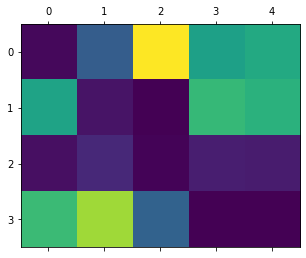

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs.shape

(5, 10, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': array([3.]), 'allele_prior_alpha': array([1.]), 'allele_prior_beta': array([1.])}


# Get VB params 

In [8]:
k_approx = 8

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = True

_, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (10, 8, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (5, 7) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (5, 7) (lb=0.0, ub=inf)


In [11]:
# set random vb parameters 
len_free = len(vb_params_paragami.flatten(vb_params_paragami.random(), free = True))
np.random.seed(2341324)
vb_params_free = np.random.randn(len_free)

# convert to dictionary 
vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)

In [12]:
structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                            use_logitnormal_sticks,
                            gh_loc, gh_weights)

310.598341369007

# Define objective

In [13]:
objective = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = vb_params_paragami,
                                    free = True,
                                    argnums = 1)

objective_fun = lambda x: objective(g_obs, x, prior_params_dict, 
                                    use_logitnormal_sticks = use_logitnormal_sticks,
                                    gh_loc = gh_loc,
                                    gh_weights = gh_weights)

In [14]:
# get derivative functions
obj_fun_grad = autograd.grad(objective_fun)
obj_fun_hess = autograd.hessian(objective_fun)

In [15]:
objective_fun(vb_params_free)

310.598341369007

# Save results

In [16]:
vb_params_flattened = vb_params_paragami.flatten(vb_params_dict, free = False)

In [17]:
np.savez(file = './tmp', 
         g_obs = g_obs, 
         vb_params_free = vb_params_free, 
         vb_params_flattened = vb_params_flattened,
         kl = objective_fun(vb_params_free), 
         kl_grad = obj_fun_grad(vb_params_free), 
         kl_hess = obj_fun_hess(vb_params_free))